# IMDB Sentiment Analysis
This notebook builds a PyTorch sentiment-classifier for the IMDB 50K reviews dataset. It demonstrates: clean, reproducible data handling with `DataLoader`s, an interpretable Bag-of-Words pipeline (`CountVectorizer`), a compact neural network (1000 -> 64 -> 1) with `Dropout` to reduce overfitting, device-agnostic training (GPU if available), epoch-level validation, and clear visualizations for losses and accuracy. 

To try it out, run the cells in order!

## Setup
- DataLoader: Efficient batching and memory-friendly training; demonstrates production-aware code.
- Dropout: Prevents overfitting by randomly zeroing activations during training.
- Split before vectorizing: Prevents information leakage; vectorizer is fit only on training text.
- Training strategy: BCELoss with Sigmoid output (explicit probability), SGD optimizer (lr=0.01), 20 epochs, batch size 64.


In [46]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [47]:
#!pip install kagglehub

In [48]:
# Imports and device setup
import os
import re
import random
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device-agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Training hyperparameters
EPOCHS = 20
BATCH_SIZE = 64
MAX_FEATURES = 2000  # vocabulary size for CountVectorizer


Using device: cpu


## Data Loading & Cleaning
Load raw reviews and perform simple cleaning (lowercase, remove HTML), then split into train/test. Splitting before vectorizing prevents leaking vocabulary/statistics from the test set into training.

In [49]:
# Load IMDB dataset from local CSV file
local_csv = 'IMDB_Dataset.csv'
if not os.path.exists(local_csv):
    raise FileNotFoundError(f'{local_csv} not found. Please place IMDB_Dataset.csv next to this notebook.')
df = pd.read_csv(local_csv)
assert 'review' in df.columns and 'sentiment' in df.columns, 'CSV must contain `review` and `sentiment` columns.'

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_review'] = df['review'].apply(clean_text)
df['label'] = df['sentiment'].map({'positive':1, 'negative':0})

print('Loaded', len(df), 'rows — positive:', df['label'].sum(), 'negative:', (len(df)-df['label'].sum()))

Loaded 50000 rows — positive: 25000 negative: 25000


## Train/Test Split & Vectorization
Split raw text into training and testing (80/20) before fitting `CountVectorizer` to avoid leaking test-set token statistics into the model.

In [50]:
# Split the data (80/20)
X = df['clean_review'].values
y = df['label'].values
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# Fit CountVectorizer on training text only
vectorizer = CountVectorizer(max_features=MAX_FEATURES)
X_train = vectorizer.fit_transform(X_train_text).toarray()
X_test = vectorizer.transform(X_test_text).toarray()

print('Vocabulary size (features):', X_train.shape[1])

Vocabulary size (features): 2000


## PyTorch Dataset & DataLoader
A `Dataset` wraps arrays/tensors and a `DataLoader` creates shuffled batches. This keeps memory usage predictable and demonstrates professional handling of data pipelines.

In [51]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SentimentDataset(X_train, y_train)
test_ds = SentimentDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print('Train batches:', len(train_loader), 'Test batches:', len(test_loader))

Train batches: 625 Test batches: 157


## Model Definition - Dropout
Dropout randomly zeroes activations during training, which discourages co-adaptation of neurons and reduces overfitting. Useful for small networks on text features.

In [52]:
class SentimentModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

model = SentimentModel(input_dim=X_train.shape[1]).to(device)
print(model)

SentimentModel(
  (fc1): Linear(in_features=2000, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## Training Loop with Validation
Run 20 epochs, track training and test loss/accuracy after each epoch, and switch between `model.train()` and `model.eval()` appropriately. Labels are float tensors compatible with `BCELoss`.

In [53]:
# Loss, optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Metrics storage
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(1, EPOCHS+1):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        preds = (outputs >= 0.5).long()
        correct += (preds == y_batch.long()).sum().item()
        total += X_batch.size(0)
    epoch_train_loss = running_loss / total
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Validation / Test
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            preds = (outputs >= 0.5).long()
            val_correct += (preds == y_batch.long()).sum().item()
            val_total += X_batch.size(0)
    epoch_val_loss = val_loss / val_total
    epoch_val_acc = val_correct / val_total
    test_losses.append(epoch_val_loss)
    test_accuracies.append(epoch_val_acc)

    if epoch % 5 == 0 or epoch == 1:
        print(f'Epoch {epoch}/{EPOCHS} — Train loss: {epoch_train_loss:.4f}, Train acc: {epoch_train_acc:.4f} | Test loss: {epoch_val_loss:.4f}, Test acc: {epoch_val_acc:.4f}')

print(f'Training complete! Final Test Accuracy: {test_accuracies[-1]:.4f}')


Epoch 1/20 — Train loss: 0.5970, Train acc: 0.6994 | Test loss: 0.5063, Test acc: 0.7931
Epoch 5/20 — Train loss: 0.3710, Train acc: 0.8482 | Test loss: 0.3538, Test acc: 0.8571
Epoch 10/20 — Train loss: 0.3109, Train acc: 0.8731 | Test loss: 0.3027, Test acc: 0.8782
Epoch 15/20 — Train loss: 0.2827, Train acc: 0.8851 | Test loss: 0.2898, Test acc: 0.8823
Epoch 20/20 — Train loss: 0.2634, Train acc: 0.8922 | Test loss: 0.2919, Test acc: 0.8766
Training complete! Final Test Accuracy: 0.8766


## Visualizations - Loss and Accuracy over Epochs
Plot training vs test loss and accuracy side-by-side to demonstrate model behaviour across epochs.

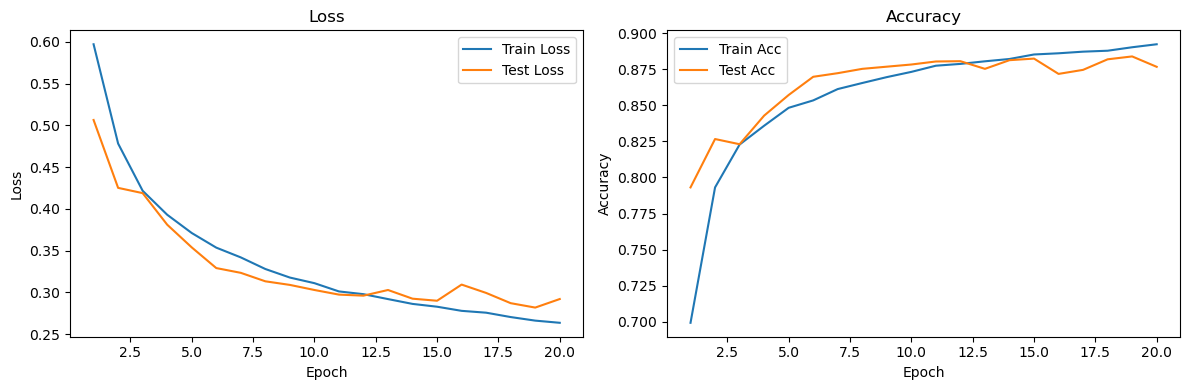

In [54]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
# Loss plot
axes[0].plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
axes[0].plot(range(1, EPOCHS+1), test_losses, label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')
# Accuracy plot
axes[1].plot(range(1, EPOCHS+1), train_accuracies, label='Train Acc')
axes[1].plot(range(1, EPOCHS+1), test_accuracies, label='Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Accuracy')
plt.tight_layout()
plt.show()

## Inference Helper - predict_review
A convenience function to clean a raw sentence, vectorize with the trained `CountVectorizer`, and return a human-friendly prediction with probability.

In [55]:
def predict_review(raw_text, model=model, vectorizer=vectorizer, device=device):
    model.eval()
    text = clean_text(raw_text)
    vec = vectorizer.transform([text]).toarray()
    x = torch.from_numpy(vec).float().to(device)
    with torch.no_grad():
        prob = model(x).item()
    label = 'Positive' if prob >= 0.5 else 'Negative'
    return f'Prediction: {label} (Probability: {prob:.2f})'

# Example usage:
print(predict_review('This movie was fantastic! Loved the acting and story.'))

Prediction: Positive (Probability: 0.81)
